In [1]:
import matplotlib.pyplot as plt
import msprime
import numpy as np
from tests.test_ld_matrix import ld_matrix

In [2]:
# sequence_length=25
sequence_length = 11
seed = 4
Ne = 10_000
mu = 2e-4
r = 1.25e-5
ts = msprime.sim_ancestry(
    samples=10,
    population_size=Ne,
    recombination_rate=r,
    sequence_length=sequence_length,
    random_seed=seed,
)

In [3]:
SEED = 23
N_REPS = 1_000_000
STATS = [
    "D2_unbiased",
    "Dz_unbiased",
    "pi2_unbiased",
    "r2",
    "D2",
]
LABELS = {
    "D2_unbiased": r"$\hat{D^2}$",
    "Dz_unbiased": r"$\hat{D^z}$",
    "pi2_unbiased": r"$\hat{\pi_2}$",
    "r2": r"$r^2$",
    "D2": r"$D^2$",
}

In [4]:
def triu_mask(n, k):
    m = np.zeros((n, n), dtype=bool)
    m[np.triu_indices(n, k=k)] = True
    return m


def relative_error(observed, expected):
    return np.abs(observed - expected) / expected


def relative_error_branch_site(b_result, s_result, num_trees):
    # Compute for upper triangle, excluding diagonal
    return relative_error(s_result, b_result)[np.triu_indices(ts.num_trees, k=1)]


def mean_relative_error_branch_site(b_result, s_result, num_trees):
    # Do not include the diagonal in error computation
    return relative_error(s_result, b_result).mean(where=triu_mask(num_trees, k=1))


def assert_matrix_symmetric(a, stat):
    assert np.isclose(
        a, a.T
    ).all(), f'{stat if stat is not None else ""} array not symmetric'
    return a


def compute_branch_result(ts, stat, branch_lengths):
    return assert_matrix_symmetric(
        ld_matrix(ts, stat=stat, mode="branch") / branch_lengths, stat
    )


def compute_mean_site_result(ts, stat, seed, n_reps):
    return assert_matrix_symmetric(
        np.dstack(
            [t.ld_matrix(stat=stat) for t in gen_one_mut_per_tree(ts, seed, n_reps)]
        ).mean(2),
        stat,
    )

In [5]:
def get_branch_lengths(ts):
    branch_lengths = np.zeros((ts.num_trees, ts.num_trees))
    for l in ts.trees():
        for r in ts.trees():
            branch_lengths[l.index, r.index] = (
                l.total_branch_length * r.total_branch_length
            )

    return assert_matrix_symmetric(branch_lengths, None)


def gen_one_mut_per_tree(ts, seed, n):
    """
    Add mutations to tree sequences such that there is exactly 1 mutation per
    tree. This algorithm chooses a location from a uniform distribution based on
    the genomic intervals of the trees and uniformly chooses the node to drop
    the mutation on weighted by branch length.
    """
    rng = np.random.RandomState(seed)
    bp = ts.breakpoints(as_array=True)
    locs = np.vstack(
        [rng.uniform(start, stop, n) for (start, stop) in zip(bp[:-1], bp[1:])]
    )
    nodes = np.vstack(
        [
            rng.choice(
                nodes := t.preorder(),
                n,
                p=np.fromiter(
                    (t.branch_length(n) / t.total_branch_length for n in nodes),
                    np.float64,
                ),
            )
            for t in ts.trees()
        ]
    )

    new_table = ts.tables.copy()

    assert ts.tables.mutations.num_rows == 0, "tree has mutations"
    assert ts.tables.sites.num_rows == 0, "tree has sites"

    for i in range(n):
        for j in range(ts.num_trees):
            s = new_table.sites.add_row(position=locs[j, i], ancestral_state="0")
            new_table.mutations.add_row(site=s, node=nodes[j, i], derived_state="1")
        yield new_table.tree_sequence()
        new_table.mutations.clear()
        new_table.sites.clear()

In [6]:
branch_lengths = get_branch_lengths(ts)
results = {
    stat: (
        compute_branch_result(ts, stat, branch_lengths),
        compute_mean_site_result(ts, stat, SEED, N_REPS),
    )
    for stat in STATS
}

In [7]:
def plot_results(results, num_trees):
    triu_idx = np.triu_indices(num_trees, k=1)
    fig, axes = plt.subplots(len(results), 2, figsize=(10, len(results) * 3))
    xticklabels = np.array(
        [f"{i}\n{j}" for i in range(num_trees) for j in range(num_trees)]
    ).reshape(num_trees, num_trees)[triu_idx]
    fig.suptitle(
        f"Comparison of two-locus statistics from Sites and Branches in tskit ({N_REPS:,} reps)"
    )
    for i, (stat, (b_result, s_result)) in enumerate(results.items()):
        mean_err = mean_relative_error_branch_site(b_result, s_result, ts.num_trees)
        label = LABELS[stat]
        axes[i, 0].plot(b_result[triu_idx], ".-", label="branch")
        axes[i, 0].plot(s_result[triu_idx], ".-", label="site")
        axes[i, 1].plot(relative_error_branch_site(b_result, s_result, num_trees), ".-")
        axes[i, 0].set_title(label)
        axes[i, 0].legend()
        axes[i, 0].set_title(label)
        axes[i, 1].set_title(f"{label} Relative Error (mean={mean_err:.4f})")
        for ax in axes[i, :]:
            ax.set_xticks(np.arange(len(triu_idx[0])), xticklabels)
    fig.tight_layout()

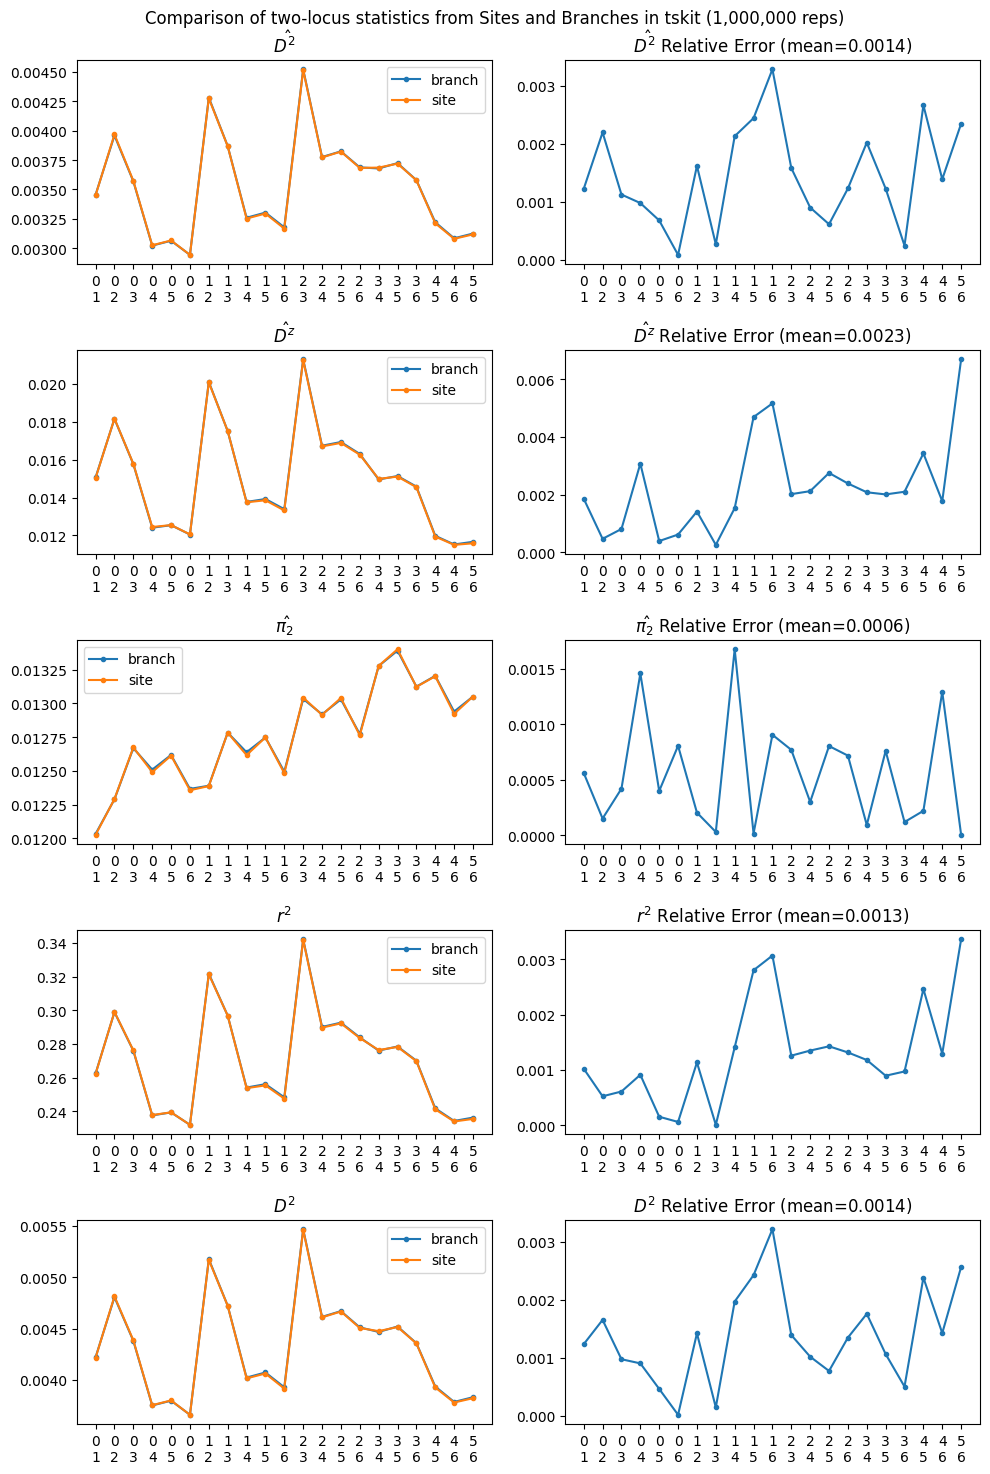

In [8]:
plot_results(results, ts.num_trees)